### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

# Index

1. Reading files and merging features with labels
2. Normalize tha features except tha labels <br>
3. Apply PCA <br>
    3.1 Further reduction of dimensions
4. Finding outliers
5. T-sne for visualization of the remainig dataset in two dimensions

# Data Description and visualization

## 1. Reading files and merging features with label

In [4]:
#dataset = pd.read_csv("Genes\data.csv")
#dataset_labels = pd.read_csv("Genes\labels.csv")

#dataset = pd.read_csv("Genes\data.csv")
dataset = pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/data.csv')

#labels = pd.read_csv("Genes\labels.csv")
dataset_labels =pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/labels.csv')


dataset = pd.merge(dataset, dataset_labels, on='Unnamed: 0').drop("Unnamed: 0", axis=1)

## 2. Normalize tha features except tha labels

In [6]:
x = dataset.iloc[:, :-1].values
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
dataset.iloc[:, :-1] = pd.DataFrame(x_scaled)

print(f'Dataset consists of {dataset.shape[0]} input sample vectors, each vector has {dataset.shape[1]} '\
      f'gene features.\nAlso the availbale classes are {len(dataset["Class"].unique())}.'\
      f' The possible choises are {", ".join(val for val in dataset.Class.unique())}.')
class_counts = dataset.Class.value_counts()
print(f'As we can see, we have class imbalance.\n\n{class_counts.to_string()}')

Dataset consists of 801 input sample vectors, each vector has 20532 gene features.
Also the availbale classes are 5. The possible choises are PRAD, LUAD, BRCA, KIRC, COAD.
As we can see, we have class imbalance.

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78


## 3. Apply PCA

In [7]:
# Create PCA object to keep 95% of variance
pca = PCA(0.95)

# Apply PCA in input vector
pca.fit(dataset.iloc[:,:-1])

# Save results in an np.array
reduced = pca.transform(dataset.iloc[:,:-1])

#Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
decomposed = pd.DataFrame(np.column_stack((reduced, x)))

#Rename columns
for column in decomposed.columns:
    if column<len(decomposed.columns)-1:
        decomposed.rename(columns={column : f"PCA{column+1}"}, inplace=True)
    else:
        decomposed.rename(columns={column : "Label"}, inplace=True)
        
print(f'Data size after PCA is: {decomposed.shape}.')

print(f'Still, there are many features, but with no significance at all. We intend to keep a minimal number of\n' \
      f'features while keeping the variance/information as high as possible\n')

Data size after PCA is: (801, 531).
Still, there are many features, but with no significance at all. We intend to keep a minimal number of
features while keeping the variance/information as high as possible



## 3.1 Further reduction of dimensions

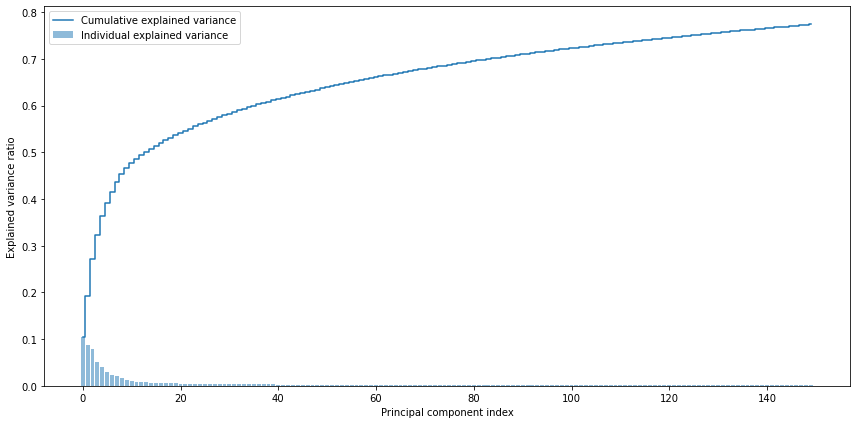

We decided to keep 100 components. This translates to about 71% information kept.

After further elimination of features we end up with the final form of the data.

        PCA1       PCA2       PCA3       PCA4       PCA5       PCA6  \
0 -57.446987  95.410981  74.301543 -12.166781   7.981831  36.157573   
1  -16.91943    0.73247   -64.0729  -2.095308  -25.42643  27.784178   
2 -70.345218 -19.303327   20.48824  48.102893  24.437757   17.46251   
3 -49.161591  -9.227586   61.24377  37.805744   1.038889  23.240002   
4 -18.132534 -51.327797  16.598116 -17.699201   26.38913  -1.551573   

        PCA7       PCA8       PCA9      PCA10  ...     PCA92     PCA93  \
0  -7.668542  19.951444   0.142216    3.03524  ...  1.866729  2.585724   
1 -16.132765 -17.031383 -22.023874 -27.923308  ...  2.576452  0.750836   
2  20.706772 -47.626817 -28.647648 -12.784676  ... -4.530058 -3.410437   
3  -4.801039 -21.554809 -15.375067 -12.881511  ...  3.226909 -4.726473   
4  -6.266101  12.336677  -4.233837  28

In [8]:
#Calculating variance ration of each component and cummulative sum.  

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot with regards of components
plt.figure(figsize=(12, 6))
plt.bar(range(0,len(exp_var_pca[:150])), exp_var_pca[:150], alpha=0.5, 
        align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[:150])), cum_sum_eigenvalues[0:150], 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Explained_variance_VS_Cumulative_sum.png")
plt.show()

print(f'We decided to keep 100 components. This translates to about 71% information kept.')

#Pick only the first 100 componets which combine for 71% of information

decomposed = pd.concat([decomposed.iloc[:,:100],decomposed.iloc[:,-1]], axis=1)

print(f'\nAfter further elimination of features we end up with the final form of the data.\n\n{decomposed.head()}')

## 4. Finding outliers

In [9]:
#Search for outliers in dataset
lof = LocalOutlierFactor()
# fit_predict return a numpy array of 1 if not an outlier and -1 if an outlier
outliers = lof.fit_predict(decomposed.iloc[:,:-1])

# select all rows that are not outliers
mask = outliers != -1

#unpack the mask to keep only non-outlier examples
decomposed = decomposed[[*mask]]

print(f'Data size after removing outliers is: {decomposed.shape}.')

Data size after removing outliers is: (773, 101).


## 5. T-sne for visualization of the remainig dataset in two dimensions

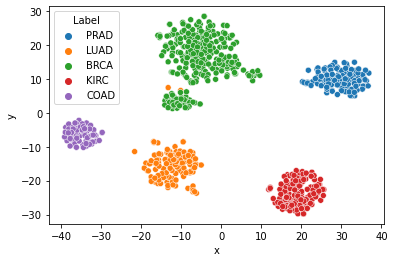

In [10]:
m = TSNE(n_components = 2, learning_rate=20)
tsne_features = m.fit_transform(decomposed.drop('Label', axis=1))

decomposed.loc[:,'x'] = tsne_features[:,0]
decomposed.loc[:,'y'] = tsne_features[:,1]
sns.scatterplot(x="x", y="y", hue='Label', data=decomposed)
plt.savefig("TSNE_visualization_algorithm.png")
plt.show()
decomposed.drop(['x', 'y'], axis=1, inplace=True)